In [37]:
import cv2 as cv
import numpy as np
from ultralytics import YOLO
from matplotlib import pyplot as plt

def grid_lines(image, grid_shape, color=(0, 255, 0), thickness=1):
    """
    Draws a grid on the given image.

    Parameters:
    - image: The input image on which to draw the grid.
    - grid_shape: A tuple (rows, cols) specifying the number of grid cells.
    - color: The color of the grid lines (default is green).
    - thickness: The thickness of the grid lines (default is 1).

    Returns:
    - The image with the grid drawn on it.
    """
    img_height, img_width = image.shape[:2]
    rows, cols = grid_shape

    # Calculate the spacing between lines
    row_height = img_height // rows
    col_width = img_width // cols

    # Draw horizontal lines
    for i in range(1, rows):
        y = i * row_height
        cv.line(image, (0, y), (img_width, y), color, thickness)

    # Draw vertical lines
    for j in range(1, cols):
        x = j * col_width
        cv.line(image, (x, 0), (x, img_height), color, thickness)

    return image

In [38]:
image = r"C:\Users\dolap\OneDrive\Documents\DOLAPO\data-analysis\photoquadrats_analysis\img\sample_img.JPG"

In [39]:
img = cv.imread(image)

In [40]:
grid_img = grid_lines(img.copy(), (4, 4), color=(255, 0, 0), thickness=2)

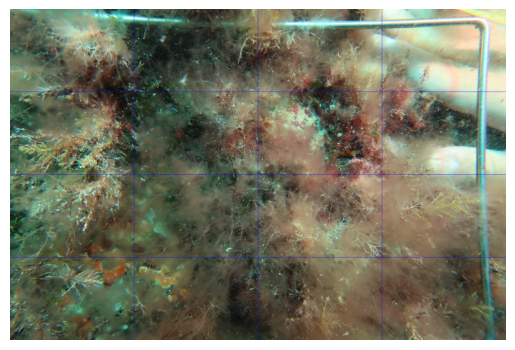

In [41]:
# visualise the image with grid in notebook

plt.imshow(cv.cvtColor(grid_img, cv.COLOR_BGR2RGB)) 
plt.axis('off')
plt.show()

### Grid Based segmentation and classification

In [48]:
def calculate_segmentation_per_grid(image, grid_shape, masks):
    """
    Calculate the area of segmentation in each grid cell.

    Parameters:
    - image: The input image.
    - grid_shape: A tuple (rows, cols) specifying the number of grid cells.
    - masks: List of segmentation masks from YOLOv8 (binary masks).

    Returns:
    - A dictionary with grid cell coordinates as keys and percentage coverage as values.
    """
    img_height, img_width = image.shape[:2]
    rows, cols = grid_shape

    # Calculate the spacing between lines
    row_height = img_height // rows
    col_width = img_width // cols

    # Initialize the grid areas dictionary
    grid_areas = {}
    for i in range(rows):
        for j in range(cols):
            grid_areas[(i, j)] = 0

    # Combine all masks into a single mask
    combined_mask = np.zeros((img_height, img_width), dtype=np.uint8)
    for mask in masks:
        # Resize mask to match image dimensions if necessary
        if mask.shape != (img_height, img_width):
            mask_resized = cv.resize(mask.astype(np.float32), (img_width, img_height))
        else:
            mask_resized = mask.astype(np.float32)
        combined_mask = cv.bitwise_or(combined_mask, (mask_resized * 255).astype(np.uint8))

    # Calculate area per grid cell
    for i in range(rows):
        for j in range(cols):
            # Define the region of interest for this grid cell
            y_start = i * row_height
            y_end = (i + 1) * row_height
            x_start = j * col_width
            x_end = (j + 1) * col_width

            # Extract the mask region for this grid cell
            grid_mask = combined_mask[y_start:y_end, x_start:x_end]

            # Count the segmented pixels (non-zero pixels)
            segmented_pixels = np.sum(grid_mask > 0)
            
            # Calculate grid cell area
            grid_cell_area = (y_end - y_start) * (x_end - x_start)
            
            # Calculate percentage coverage
            percentage_coverage = (segmented_pixels / grid_cell_area) * 100
            grid_areas[(i, j)] = percentage_coverage

    return grid_areas, combined_mask

In [49]:
def visualize_results(image, grid_shape, grid_areas, combined_mask):
    """
    Visualize the segmentation with grid and coverage percentages.

    Parameters:
    - image: The input image.
    - grid_shape: A tuple (rows, cols) specifying the number of grid cells.
    - grid_areas: Dictionary with grid coverage percentages.
    - combined_mask: The combined segmentation mask.
    """
    img_height, img_width = image.shape[:2]
    rows, cols = grid_shape
    row_height = img_height // rows
    col_width = img_width // cols

    # Create a copy for visualization
    viz_img = image.copy()

    # Overlay the segmentation mask with transparency
    mask_colored = np.zeros_like(viz_img)
    mask_colored[combined_mask > 0] = [0, 255, 0]  # Green for segmented areas
    
    alpha = 0.4  # Transparency level
    viz_img = cv.addWeighted(viz_img, 1 - alpha, mask_colored, alpha, 0)

    # Draw grid lines
    viz_img = grid_lines(viz_img, grid_shape, color=(255, 0, 0), thickness=2)

    # Add percentage text to each grid cell
    font = cv.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    text_color = (255, 255, 255)  # White text

    for i in range(rows):
        for j in range(cols):
            y_start = i * row_height
            x_start = j * col_width
            
            # Text position (center of grid cell)
            text_x = x_start + col_width // 2 - 20
            text_y = y_start + row_height // 2
            
            # Get coverage percentage
            coverage = grid_areas[(i, j)]
            
            # Draw background rectangle for text
            text = f"{coverage:.1f}%"
            text_size = cv.getTextSize(text, font, font_scale, thickness)[0]
            cv.rectangle(viz_img, 
                        (text_x - 5, text_y - text_size[1] - 5),
                        (text_x + text_size[0] + 5, text_y + 5),
                        (0, 0, 0), -1)
            
            # Draw text
            cv.putText(viz_img, text, (text_x, text_y), font, font_scale, text_color, thickness)

    return viz_img


0: 448x640 (no detections), 326.5ms
Speed: 4.7ms preprocess, 326.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)
Segmentation coverage per grid cell (confidence threshold: 0.5):
--------------------------------------------------
Grid (0, 0): 0.00%
Grid (0, 1): 0.00%
Grid (0, 2): 0.00%
Grid (0, 3): 0.00%
Grid (1, 0): 0.00%
Grid (1, 1): 0.00%
Grid (1, 2): 0.00%
Grid (1, 3): 0.00%
Grid (2, 0): 0.00%
Grid (2, 1): 0.00%
Grid (2, 2): 0.00%
Grid (2, 3): 0.00%
Grid (3, 0): 0.00%
Grid (3, 1): 0.00%
Grid (3, 2): 0.00%
Grid (3, 3): 0.00%


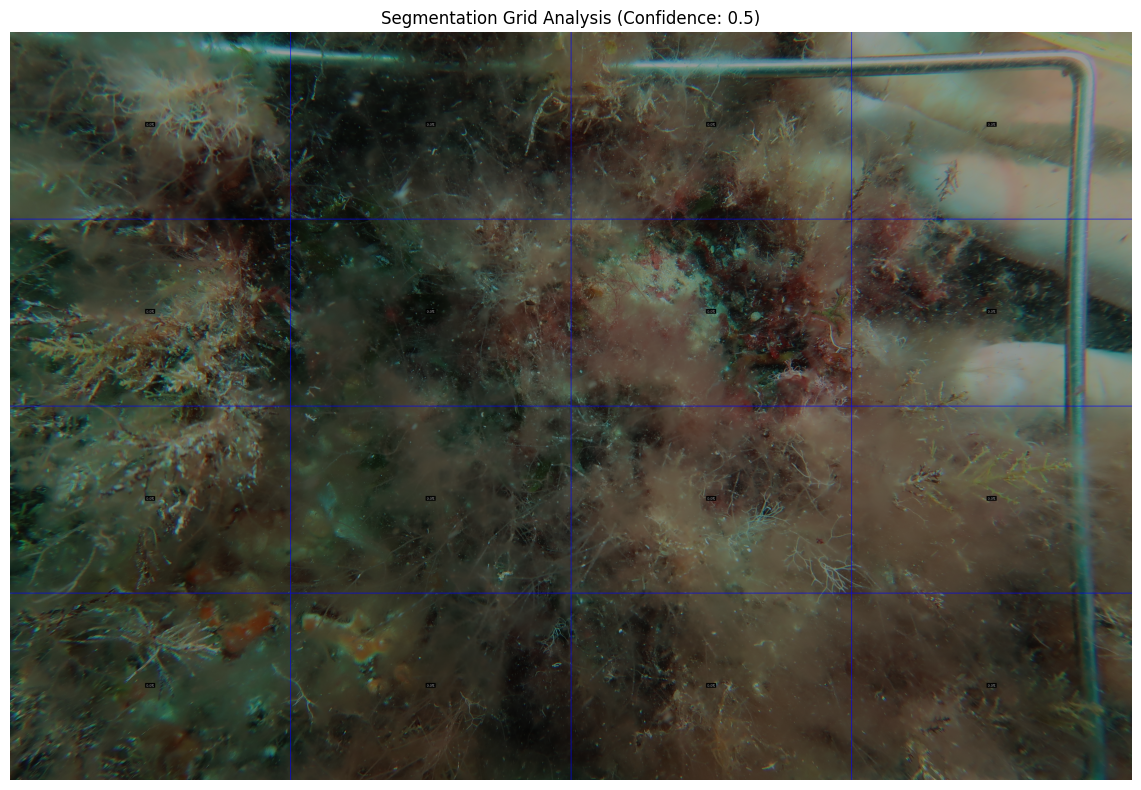

In [50]:
# Load YOLOv8 segmentation model
model = YOLO(r"C:\Users\dolap\OneDrive\Documents\DOLAPO\data-analysis\photoquadrats_analysis\model\customV8.pt")  # Use yolov8n-seg, yolov8m-seg, etc.

# Adjust confidence level here (0.0 to 1.0)
confidence_threshold = 0.5

# Run inference with confidence threshold
results = model(img, conf=confidence_threshold)

# Extract masks
masks = []
if results[0].masks is not None:
    masks = results[0].masks.data.cpu().numpy()

# Calculate segmentation area per grid
grid_shape = (4, 4)
grid_areas, combined_mask = calculate_segmentation_per_grid(img, grid_shape, masks)

# Print results
print(f"Segmentation coverage per grid cell (confidence threshold: {confidence_threshold}):")
print("-" * 50)
for (row, col), coverage in sorted(grid_areas.items()):
    print(f"Grid ({row}, {col}): {coverage:.2f}%")

# Visualize
viz_img = visualize_results(img, grid_shape, grid_areas, combined_mask)

# Display using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv.cvtColor(viz_img, cv.COLOR_BGR2RGB))
plt.title(f"Segmentation Grid Analysis (Confidence: {confidence_threshold})")
plt.axis("off")
plt.tight_layout()
plt.show()